<a href="https://colab.research.google.com/github/Jushef/Proyectos-ML-DL/blob/main/Aprendizaje%20Supervisado/Regression/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supervised Learning Models to Predict a Stock Price**

### ***1. Problem definition***

* La rentabilidad semanal de las acciones de Microsoft es la variable predicha 
* Tenemos que entender que afecta al precio de las acciones de microdoft e incorporar la mayor catidad de infotmacion al modelo
* Entre los activos correlacionados, los indicadores tecnicos y el analisis fundamental nos centraremos en los activos correlacionados como caracteristicas
* Las variables independientes utilizadas son los siguientes activos pontencialmente correlacionados:

  ***Stocks:***
           IBM (IBM) and Alphabet (GOOGL)
  ***Currency:***
           USD/JPY and GBP/USD
  ***Indices:***
           S&P500, Dow Jones, and VIX
       
* El Dataset utilizado para este estudio se extrae de Yahooo finace y del sitio web de la Fred 
* Utilizaremos el precio de cierrede los ultimos 11 años 

### ***2. Loading the Python Packages***

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 19.7 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# Funciones y Modulos para los modelos de regresion supervisada 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Funciones y Modulos para el analisis de datos y evaluacion de modelos 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Funciones y modulos para modelos de Deep Learning
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Funciones y modulos para modelos de Series de Tiempo 
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# Funciones y modulos  para la preparacion y visualizacion de datos
## pandas, pandas_datareader, numpy and matplotlib
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix 
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
import yfinance as yf
import datetime

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### ***3. Loading the data***

In [ ]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 11, 30)

In [ ]:
yf.pdr_override()

stk_data = pdr.get_data_yahoo(stk_tickers, start= start, end= end)
ccy_data = pdr.get_data_fred(ccy_tickers, start= start, end= end)
idx_data = pdr.get_data_fred(idx_tickers, start= start, end= end)

[*********************100%***********************]  3 of 3 completed


In [ ]:
return_period = 5


Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]


* Acontinuacion definimos nuestras variables dependientes (Y) e independientes (X)
* La varieble prevista es la rentavilidad semanal de Microsoft 
* Se supone que el numero de dias de negociacion en una semana es de 5 y calculamos la rentabilidad utilizando 5 dias de negociacion
* Como variables independientes utilizamos los activos correlacionados y la rentavilidad historica de Microsoft con diferentes frecuencias 
* Las variables utilizadas como variables independientes  son la entabilidad rezagada de cinco dias de las acciones (IBM, GOOG),  las divisas (USD/JPY e GBP/USD) y los indices (S&P500, Dow Jones y VIX), junto a la rentabilidad rezagada de 5, 15, 30, 60 dias de MSFT
* Las variables retardadas de cinco dias incorporan el componente de la serie temporal mediante un enfoque de retardo, en el que la variable retardada se incluye como una de las variables independientes 
* Este paso consiste en reformular los datos de las series temporales en un marco de modelo basado en la regresion supervisada   

### ***Exploratory data analysis***

In [ ]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2011-12-15,0.009734,0.005649,-0.021633,0.002572,-0.009576,-0.015183,-0.010801,-0.197407,0.006279,0.043581,-0.009951,-0.009182
2011-12-22,0.005795,0.016266,-0.029446,0.003333,0.011620,0.030977,0.025031,-0.171154,0.009734,0.020748,-0.007496,0.016453
2011-12-30,0.066318,0.025401,0.010057,-0.014828,-0.005008,-0.006128,-0.006237,0.121154,0.005795,0.021808,-0.004228,0.010202
2012-01-10,0.013912,-0.065632,-0.027150,0.002215,-0.010660,0.011693,0.005237,-0.104539,0.039192,0.068378,0.135997,0.031494
2012-01-18,0.046037,0.015557,-0.001325,-0.001171,0.005531,0.011967,0.010348,-0.007630,0.013912,0.081136,0.112748,0.050570


In [ ]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,473.000,473.000,4.730e+02,4.730e+02,4.730e+02,473.000,473.000,4.730e+02,473.000,473.000,473.000,473.000
mean,0.005,0.004,-3.534e-04,8.057e-04,-3.861e-04,0.003,0.002,-7.212e-04,0.006,0.018,0.034,0.065
std,0.032,0.033,3.212e-02,1.236e-02,1.169e-02,0.021,0.022,1.625e-01,0.032,0.049,0.066,0.086
min,-0.179,-0.168,-2.312e-01,-4.752e-02,-7.267e-02,-0.198,-0.209,-5.562e-01,-0.179,-0.282,-0.229,-0.151
25%,-0.010,-0.013,-1.334e-02,-6.085e-03,-7.745e-03,-0.005,-0.006,-8.191e-02,-0.009,-0.008,-0.004,0.011
50%,0.007,0.006,1.606e-03,7.854e-04,-7.766e-05,0.004,0.004,-6.916e-03,0.007,0.021,0.037,0.071
75%,0.023,0.023,1.573e-02,7.751e-03,6.281e-03,0.013,0.012,7.194e-02,0.024,0.046,0.078,0.119
max,0.142,0.192,1.215e-01,6.909e-02,4.258e-02,0.099,0.116,1.141e+00,0.142,0.169,0.264,0.377


* La variable MSFT_pred es el rendiemiento de las acciones de Microsoft y es la variable predicha 

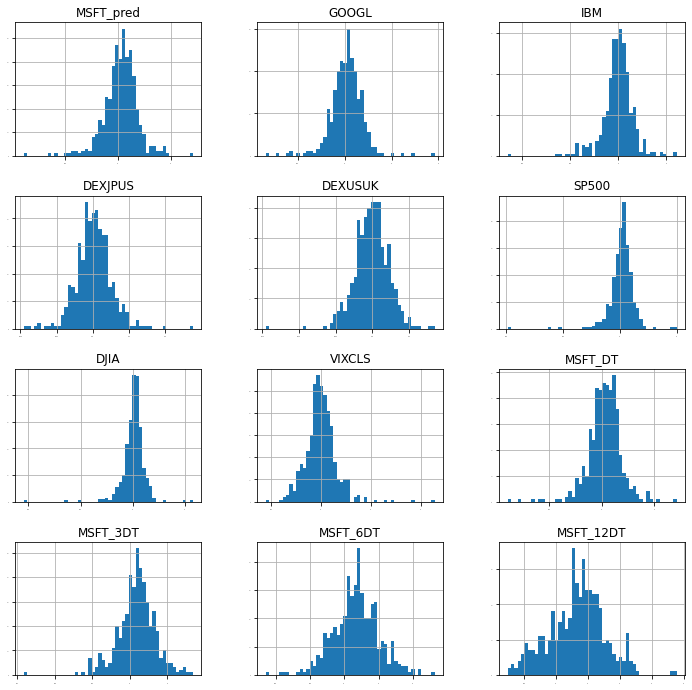

In [ ]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

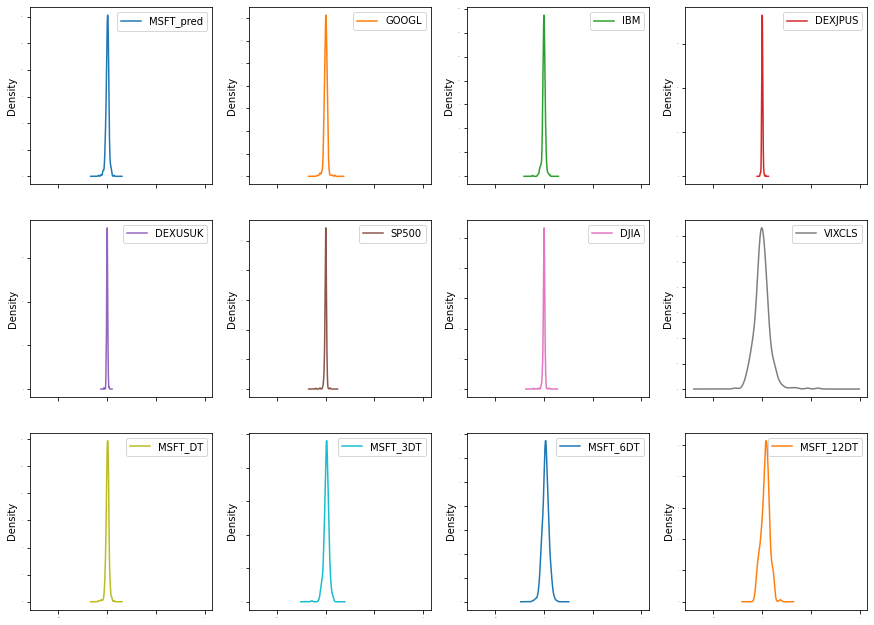

In [ ]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()

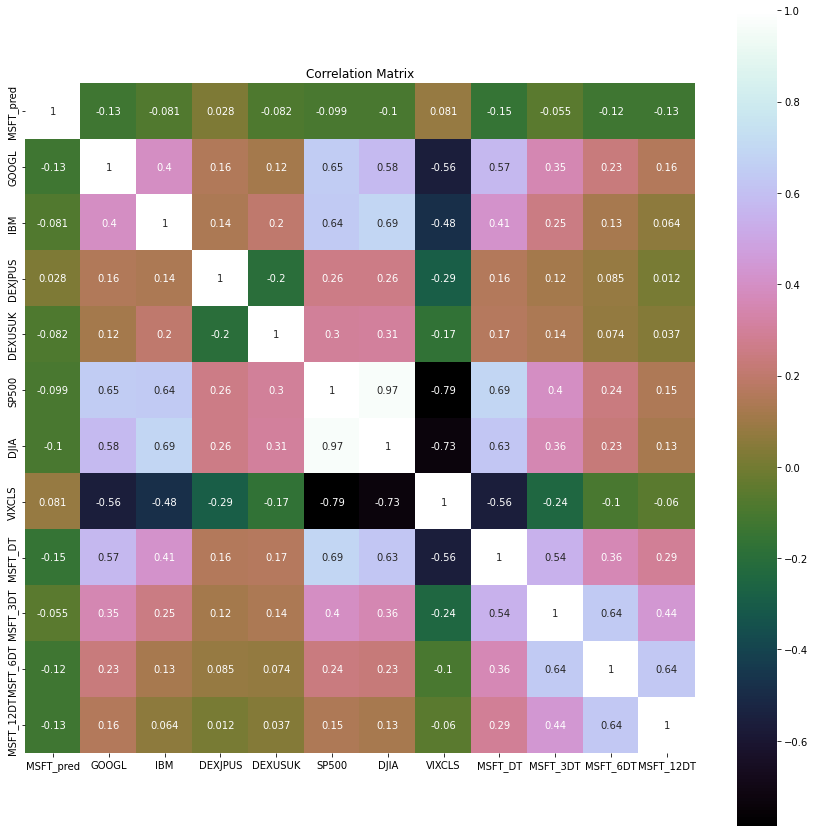

In [ ]:
corr = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(corr, vmax=1, square=True, annot=True, cmap='cubehelix')

* Vemos cierta correlacion de la variable pronosticada con los rendimientos resagados de 5, 15, 30 y 80 dias de MSFT
* Ademas vemos una mayor correlacion negativa de los rendimientos de muchos activos frente al VIX, lo cual es intuitivo 

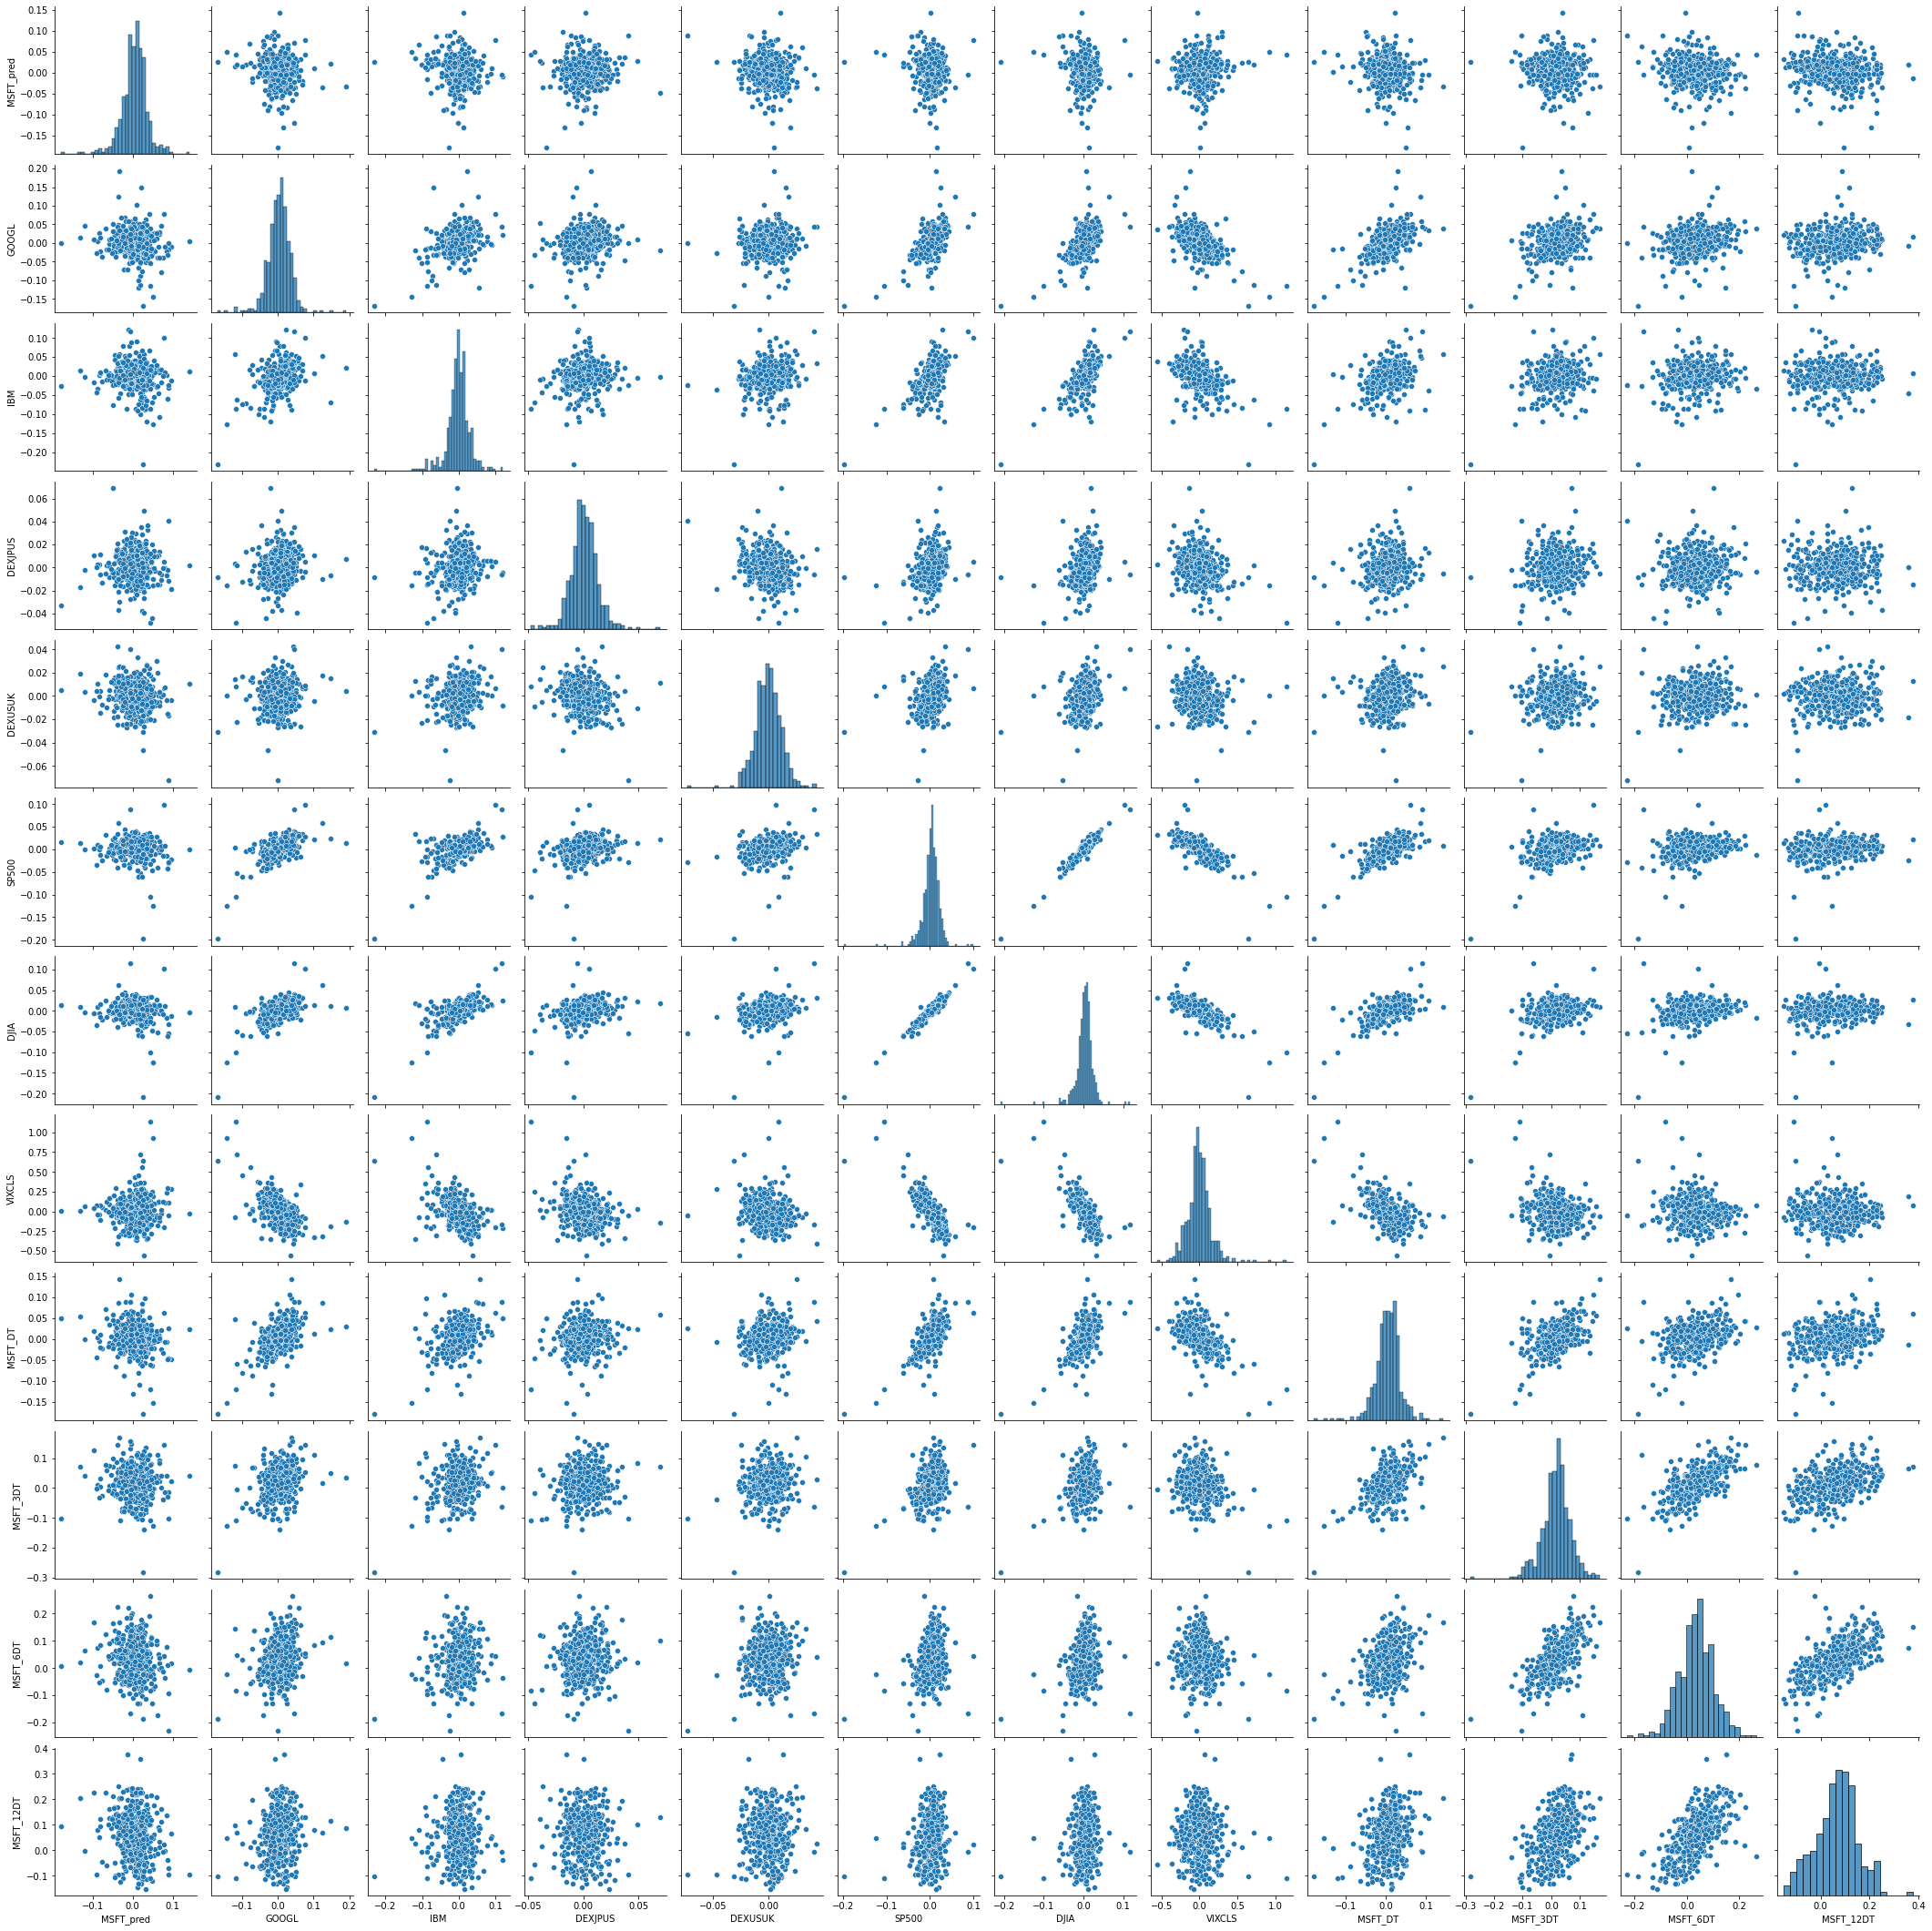

In [ ]:
sns.pairplot(dataset, palette='Set2')

* Vemos cierta relacion lineal de la variable predicha con los rendimientos resagados de 15, 30 y 60 dias de MSFT 
* Por lo demas no vemos ninguna relacion especial entre nuestra variable predicha y las caracteristicas

###***Time series analysis***

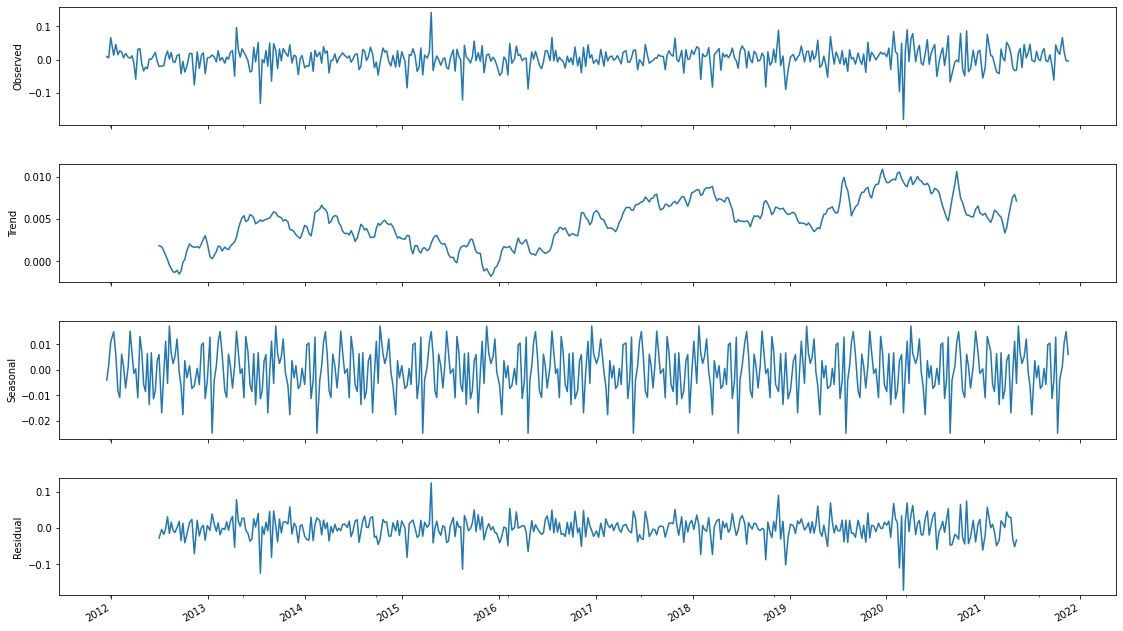

In [ ]:
res = sm.tsa.seasonal_decompose(Y, freq=52)
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(18)
plt.show();

* Descompocision de la serie temporal de la variable predicha Y.
* Podemos ver que para MSFT ha habido una tendencia general al alza. 

###***Feature Selection***

* Usamos la función SelectKBest de sklearn para tener una idea de la importancia de las características.

In [ ]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_DT,11.167
MSFT_12DT,8.071
GOOGL,7.501
MSFT_6DT,7.399
DJIA,4.748
SP500,4.690
DEXUSUK,3.213
VIXCLS,3.141
IBM,3.110


* Vemos que MSFT_DT parece ser la característica más importante y vix es la menos importante.

###***Evaluate models***

In [ ]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [ ]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

In [ ]:
# Regression and tree regression algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# Neural Network algorithms
models.append(('MLP', MLPRegressor()))

# Ensamble Models 

## Boosting methods
models.append(('ARB',AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

## Baggin methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [ ]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle= True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000851 (0.000305) 0.000788 0.001762
LASSO: 0.000833 (0.000307) 0.000828 0.001686
EN: 0.000833 (0.000307) 0.000828 0.001686
KNN: 0.000927 (0.000361) 0.000592 0.001800
CART: 0.001831 (0.000499) 0.000000 0.002683
SVR: 0.001238 (0.000335) 0.001158 0.002074
MLP: 0.001133 (0.000323) 0.000942 0.001635
ARB: 0.000987 (0.000319) 0.000550 0.001710
GBR: 0.001035 (0.000375) 0.000216 0.001756
RFR: 0.000941 (0.000356) 0.000126 0.001586
ETR: 0.000960 (0.000381) 0.000000 0.001582


Hacemos un bucle sobre cada uno de los modelos:
  * En primer lugar ejecutamos el analisis k.fold.
  * A continuacion ejecutamos el modelo en todo el conjunto de entrenamiento y prueba.
  * Todos los algoritmos utilizan parametros de ajuste por defecto. 
  * Calcularemos la media y la desviacion estandar de la metrica de evaluacion para cada algoritmo y recogemos los resultados para la comparacion de modelos.

#### *Resultados de la validacion cruzada*

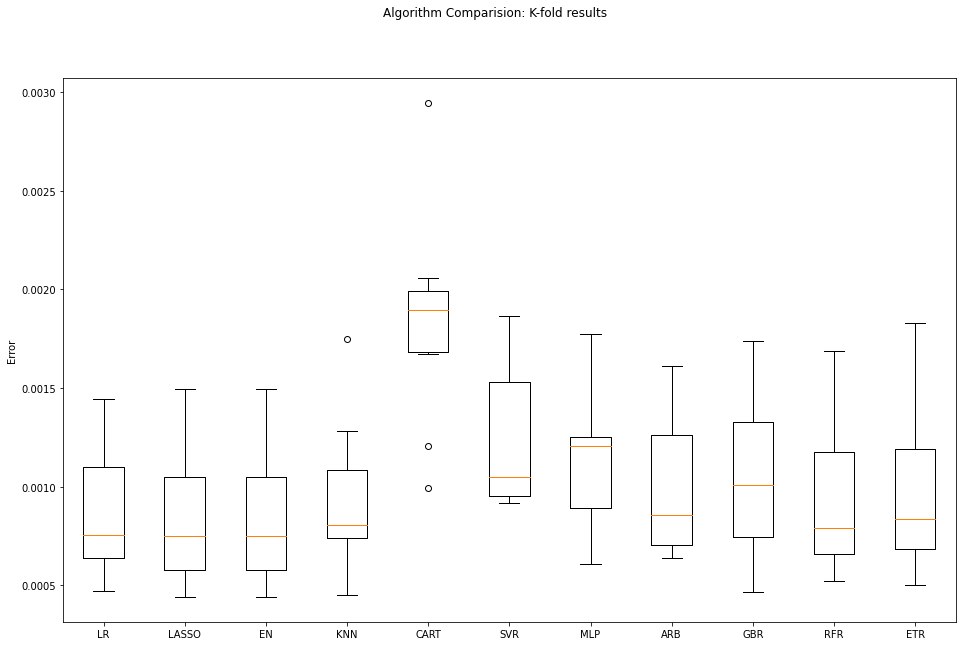

In [ ]:
fig =  plt.figure()
fig.suptitle('Algorithm Comparision: K-fold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
ax.set_ylabel('Error')
fig.set_size_inches(16,10)
plt.show();

* Vemos que la regresion lineal y la regresion regularizada que incluyen la regresion lasso y la red elastica parecen tener un buen rendimiento. Esto nos indica una fuerte relacion lineal entre la variables dependientes e independientes.
* Volviendo al analisis exploratorio observanos una buena correlacion y relacion lineal de las variables objetivo con las diferentes variables MSFT rezagadas 

#### *Training and Test error*

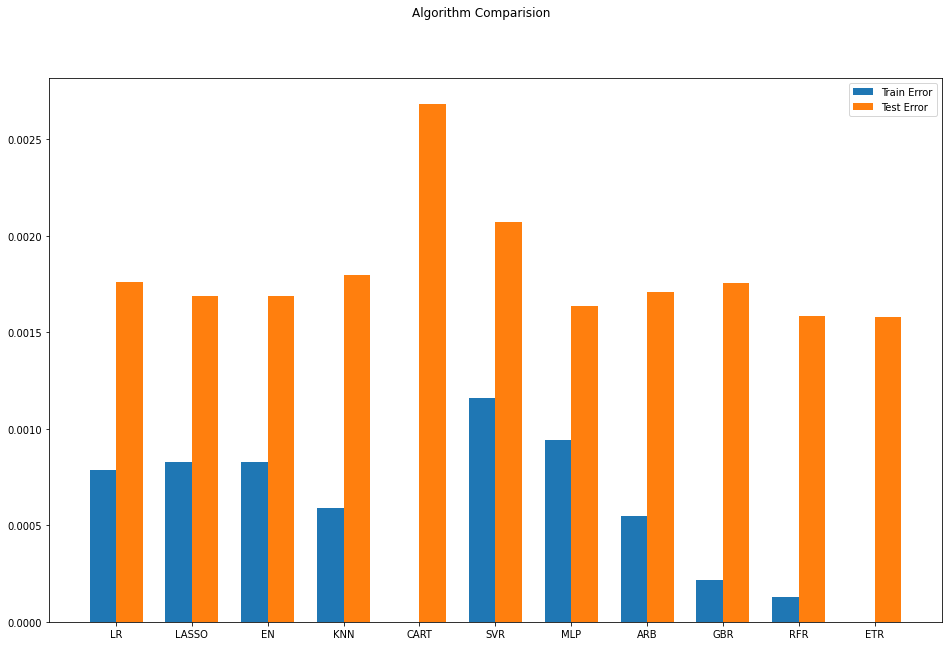

In [ ]:
# Compare algorithms
fig = plt.figure()

ind = np.arange(len(names)) # Las ubicaciones x de los grupos
width = 0.35

fig.suptitle('Algorithm Comparision')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results, width= width, label ='Train Error')
plt.bar(ind + width/2, test_results, width= width, label = 'Test Error')
fig.set_size_inches(16,10)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show();

Al examinar el error  de entrenamiento y prueba:

* Seguimos viendo un mayor rendimiento en los modelos lineales. 
* Algunos algoritmos como el CART se ajustan en exceso a los datos de entrenamiento y producen un error muy elevado en el conjunto de pruebas. 
* Los modelos de conjunto como la regresión por gradiente y la regresión por bosque aleatorio tiene un sesgo alto y una varianza alta.
* También vamos que el algoritmo de red neuronal artificial MLP, muestra errores más elevados tanto en el conjunto de entrenamiento y prueba. Esto puede deberse a que la relación lineal de las variables no e captada con precisión por la RNA, a unos hiperparametros inadecuados o a un entrenamiento insuficiente del modelo.
* Nuestra intuición original a partir de los resultados de la validación cruzada y los gráficos de dispersión también parecen demostrar un mejor rendimiento de los modelos lineales.


### ***Time series - based models: ARIMA and LSTM***

In [ ]:
X_train_ARIMA = X_train.loc[:, ['GOOGL','IBM','DEXJPUS','SP500','DJIA','VIXCLS']]

In [ ]:
X_test_ARIMA = X_test.loc[:, ['GOOGL','IBM','DEXJPUS','SP500','DJIA','VIXCLS']]

In [ ]:
tr_len = len(X_train_ARIMA)

In [ ]:
te_len = len(X_test_ARIMA)

In [ ]:
to_len = len(X)

In [ ]:
modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1,0,0]) 
model_fit = modelARIMA.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


* Ahora configuramos el modelo ARIMA con orden (1,0,0) y utilizamos la variables independientes como variables exogenas en el modelo. 
* La versión del modelo ARIMA que utiliza las variables exogenas se conoce  como modelo ARIMAX.

In [ ]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start=tr_len - 1, end=to_len - 1, exog=X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test, predicted)
print(f'Mean Squared error Train: {error_Training_ARIMA}\nMean Squared error Test: {error_Test_ARIMA}')


Mean Squared error Train: 0.0007956614460152486
Mean Squared error Test: 0.0018485466833493471


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


* El error del modelo ARIMAX es razonable 

In [ ]:
seq_len = 2 # Length of the seq for the LSTM 


Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0] + 1 - seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))

for i in range(seq_len):
  X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
  X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]


In [ ]:
learn_rate = 0.01
momentum = 0.9

# LSTM NETWORK 
def create_LSTMModel(learn_rate, momentum):
  ## Create Model
  model = Sequential()
  model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
  ## More cells can be added if needed
  model.add(Dense(1)) 
  optimizer = SGD(lr= learn_rate, momentum= momentum)
  model.compile(loss='mse', optimizer= 'adam')
  return model 


LSTMModel = create_LSTMModel(learn_rate, momentum)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data= (X_test_LSTM, Y_test_LSTM),
                             epochs= 330, batch_size= 72, verbose= 0, shuffle= False)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


* La entrada de la LSTM esta en X_train_LSTM, que tiene 50 capas ocultas en la capa LSTM y luego se transforma en una unica capa de salida: el valor de retorno de las acciones.

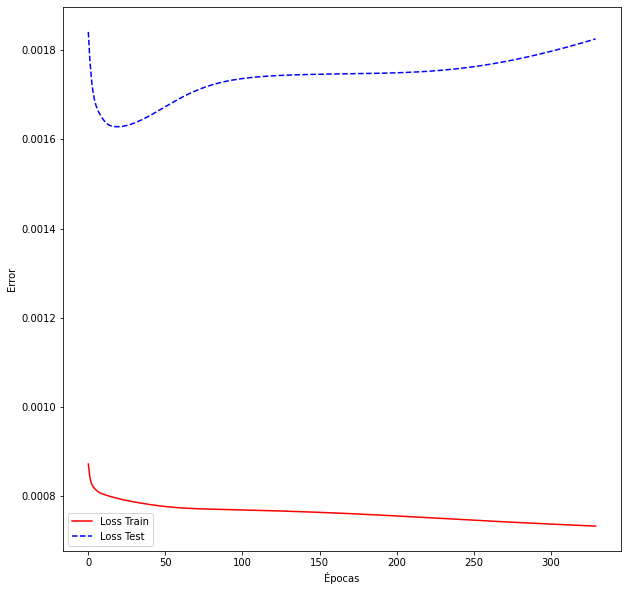

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(LSTMModel_fit.history['loss'], 'r-', label= 'Loss Train')
plt.plot(LSTMModel_fit.history['val_loss'], 'b--', label= 'Loss Test')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.legend()
plt.show();

In [ ]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM,
                                          LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test, predicted)

In [ ]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append('ARIMA')
names.append('LSTM')

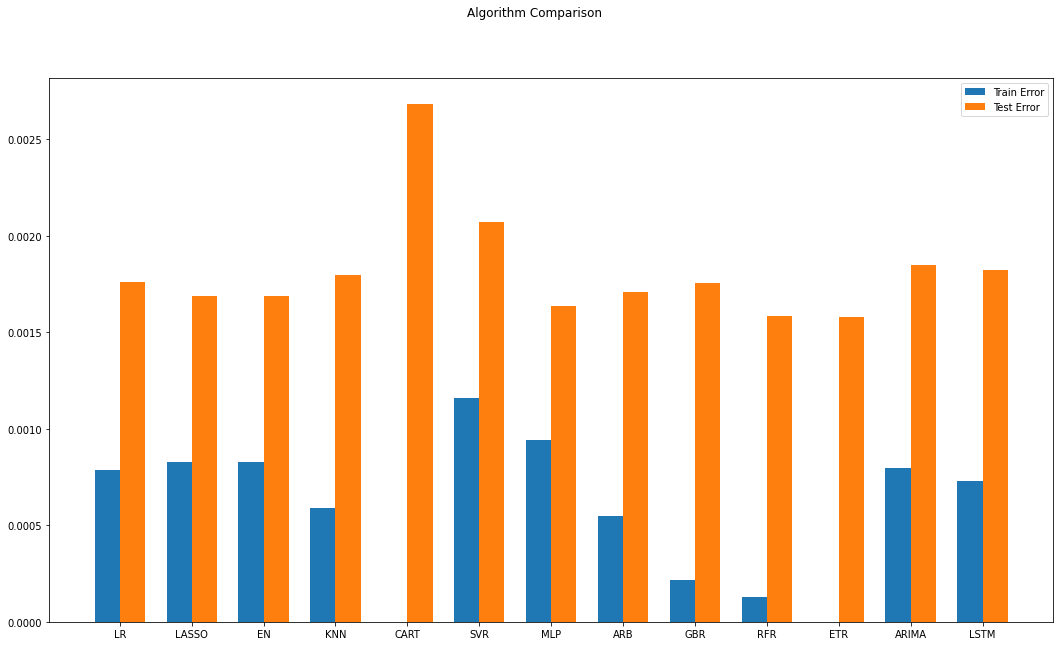

In [ ]:
fig = plt.figure()

ind = np.arange(len(names))
width= 0.35

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results, width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width= width, label='Test Error')
fig.set_size_inches(18,10)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names) 
plt.show();


###***Model Tuning and grid search***

In [ ]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))


import warnings
  
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0008125
ARIMA(0, 0, 1) MSE=0.0007961
ARIMA(1, 0, 0) MSE=0.0007957
ARIMA(1, 0, 1) MSE=0.0007956
ARIMA(2, 0, 0) MSE=0.0007956
ARIMA(2, 0, 1) MSE=0.0007949
Best ARIMA(2, 0, 1) MSE=0.0007949


* Vemos que el modelo ARIMA(2,0,1) "ARMA" es el que mejor se comporta de todas las combinaciones probadas.
* Aunque no hay una diferencia significativa en el error cuadratico medio 
no hay que olvidar el hecho que hay otras variables exogenas en el modelo que influyen (ARMAX).

In [ ]:
#Prepare model
modelARIMA_tuned = ARIMA(endog=Y_train, exog= X_train_ARIMA, order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

# Estimate accuracy on validation set 
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0018485466833493471


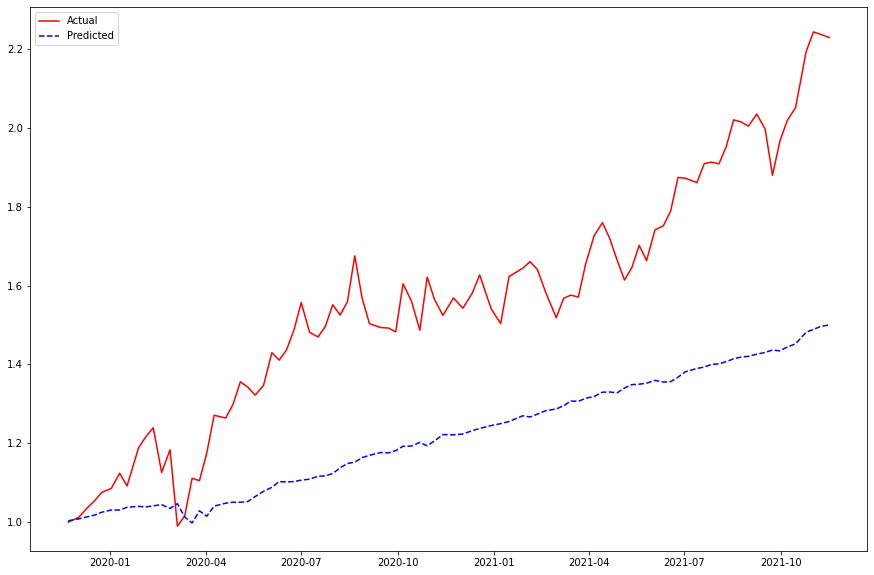

In [ ]:
# Plotting the actual data vs predicted data  
predicted_tuned.index = Y_test.index
plt.plot(np.exp(Y_test).cumprod(), 'r', label='Actual')

plt.plot (np.exp(predicted_tuned).cumprod(), 'b--', label= 'Predicted')
plt.legend()
plt.rcParams['figure.figsize'] = (12,6)
plt.show()

* La tendencia ha sido captada perfectamente por el modelo.
* La serie predicha es menos volatil en comparación con la serie real y se ajusta a los datos reales de los primeros meses del conjunto de pruebas.
* Un punto en tener en cuenta es que el objetivo del modelo es calcular la rentabilidad del dia siguiente apartir de los datos observados hasta el momento, y no predecir el preco de las acciones varios dias en el futuro apartir de los datos actuales.
* Por lo tanto, se espera una desviacion de los datos actuales a mediada que nos alejamos del inicia del conjunto de prubas.  

###***Guardar modelo para uso posterior***

In [ ]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

###***Resumen***
Podemos concluir que los modelos simples - regresión lineal, regresión regularizada (es decir, Lasso y red elástica) - junto con el modelo de series de tiempo como ARIMA son enfoques de modelado prometedores para el problema de predicción del precio de los activos. 